# Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools

# Home made linear congruential generator

A few conditions (outlined below) need to be satisfied for the period of the pseudo-random numbers
to be the maximum possible for a given modulus.

In [2]:
seed = 1

x = [seed]

m = 13*13 # m and c's greatest common divisor must be 1
c = 7
a = 13+1 # if q divides m, q has to divide a-1. If 4 divides m, 4 has to divide a-1

We can see the numbers starting to repeat by saving m+2 (the seed is the first) of them

In [3]:
for i in range(m+1):
    x.append((a*x[-1] + c) % m)
    
print("The first 3 pseudo-random nubers are:",x[:3])
print("The %i-th, %i-th, and %i-th are " %(m, m+1, m+2), x[-3:])

The first 3 pseudo-random nubers are: [1, 21, 132]
The 169-th, 170-th, and 171-th are  [72, 1, 21]


The numbers we just generated are indeed uniformely distributed, but they are quite obviously not random.
We can see this by plotting their pdf, plotting them in the order in which they have been generated, and plotting the spectral test, i.e. the couples (x_i, x_{i+1}) (in this case in 2D).

In [4]:
def plots(x):
    plt.hist(x,bins=99)
    plt.xlabel("x")
    plt.ylabel("pdf")
    plt.show()
    plt.plot(x, marker=".", lw=0)
    plt.xlabel("$i$")
    plt.ylabel("x$_i$")
    plt.show()
    plt.plot(x[:-1], x[1:], marker=".", lw=0)
    plt.xlabel("x$_i$")
    plt.ylabel("x$_{i+1}$")
    plt.show()

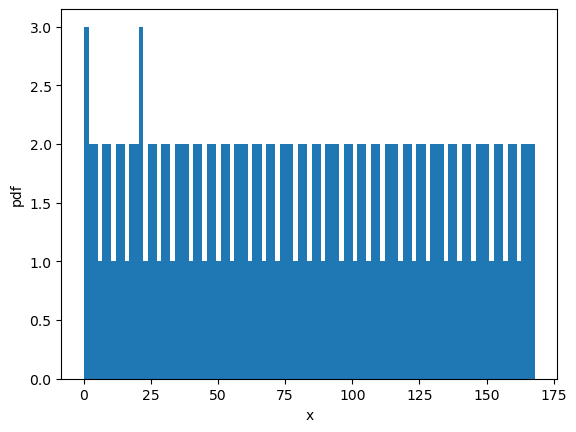

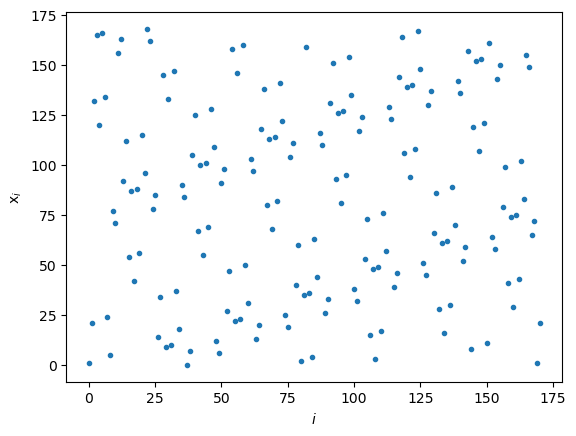

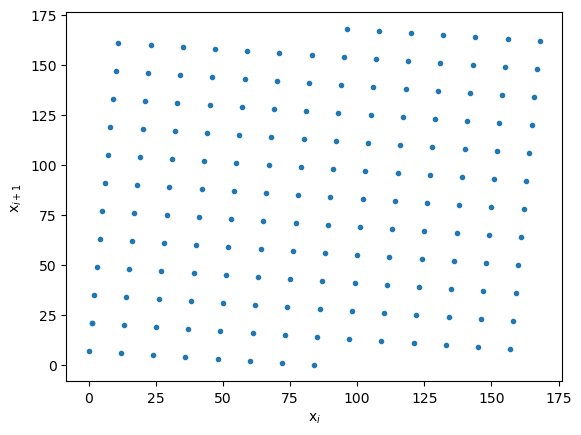

In [5]:
plots(x)

Better algorithm generates numbers which are still pseudo-random, but which evade the problems we just outlined.

# numpy.random

In [6]:
rng = np.random.default_rng(seed=1)
x = rng.random(100)

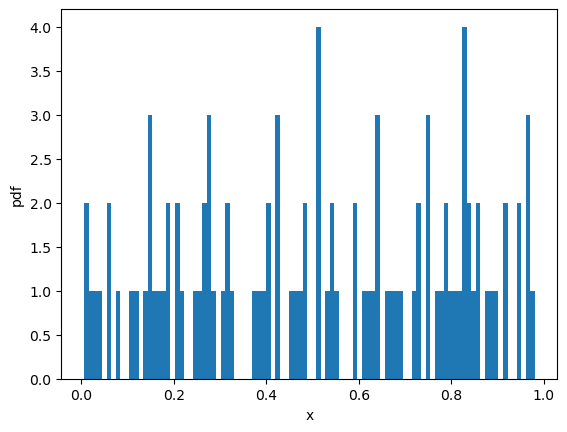

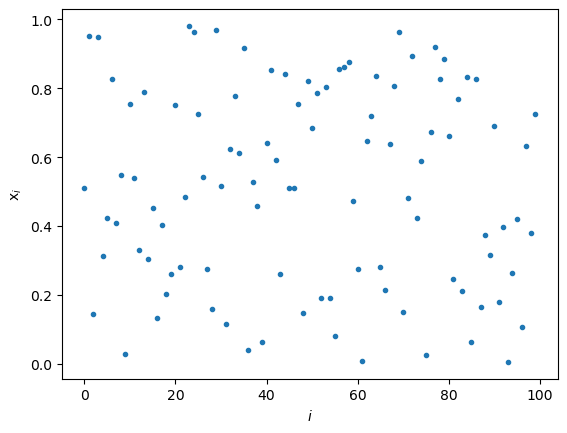

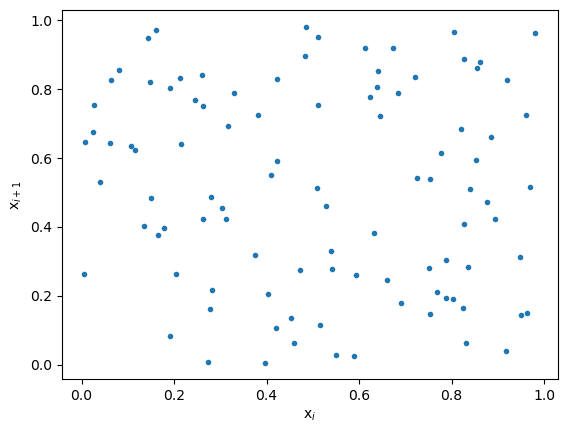

In [7]:
plots(x)

## cos distribution

Applying $\int_0^y \cos(y') dy' = x$

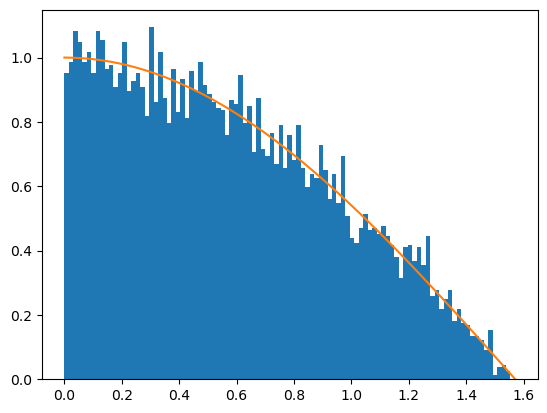

In [8]:
x = rng.random(10000)
y = np.arcsin(x) # inverse of the primitive of the pdf

plt.hist(y, bins=100, density=True)
xs = np.linspace(0,np.pi/2.)
plt.plot(xs, np.cos(xs))
plt.show()

# Monte Carlo integration

## hit or miss

We can use random numbers to evaluate integrals.
The following function f(x), which we wish to integrate in [1, 10], is braketed between the x axis and the function g(x) which is easy to integrate.
Thus, we can draw random couples (x,y) between y=0 and g(x), with an uniform distribution on the x-y plane, and count which fraction lands below f(x)

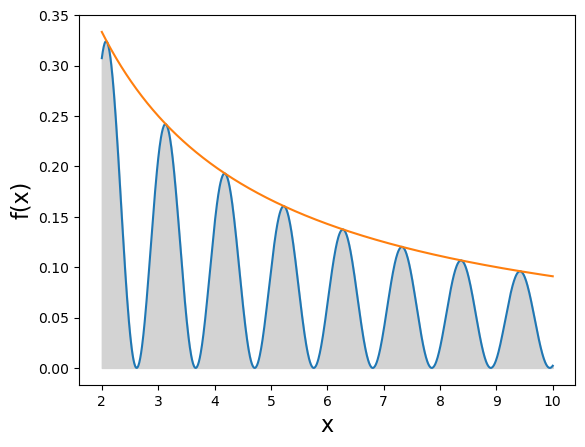

In [9]:
def f(x): 
    return np.cos(3*x)**2*(x+1)**-1

def g(x):
    return (x+1)**-1

# extremes of integration
a = 2
b = 10

x = np.linspace(a, b, 1000)
y = f(x)
plt.plot(x,y)
plt.fill_between(x,y, color='lightgray')
plt.plot(x,g(x))
plt.xlabel('x',size = 16)
plt.ylabel('f(x)', size = 16)
plt.show()

In [10]:
def Integrate_MC(f, g, invG, I, a, b, N):
    xs = invG(rng.random(N)*I) # see slides on the rejection method
    ys = f(xs)
    MCys = rng.random(N) * g(xs)
    #return I * np.sum(MCys < ys) / N, xs, MCys
    return I * np.sum(MCys < ys) / N

The primitive G of g(x) (with G(a)=0) is

In [11]:
def G(x):
    return np.log(x+1) - np.log(3)

def invG(x):
    return -1 + 3*np.exp(x)

In [12]:
integral_of_g = G(b)
Integrate_MC(f, g, invG, I=integral_of_g, a=a, b=b, N=1000000)

0.6631059616296723

Integrate another function f

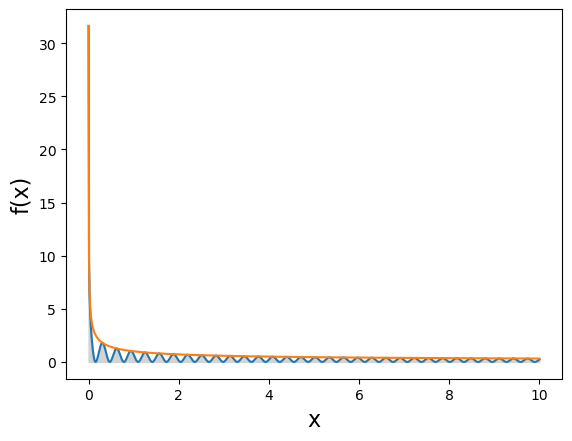

In [13]:
def f(x): 
    return np.cos(10*x)**2*x**-0.5

def g(x):
    return x**-0.5

def G(x):
    return 2*x**0.5

def invG(x):
    return 0.25*x**2

x = np.linspace(0.001,10, 1000)
y = f(x)
plt.plot(x,y)
plt.fill_between(x,y, color='lightgray')
plt.plot(x,g(x))
plt.xlabel('x',size = 16)
plt.ylabel('f(x)', size = 16)
plt.show()

In [14]:
a = 0
b = 10

integral_of_g = G(b)
Integrate_MC(f, g, invG, I=integral_of_g, a=a, b=b, N=100000)

3.30483313708877

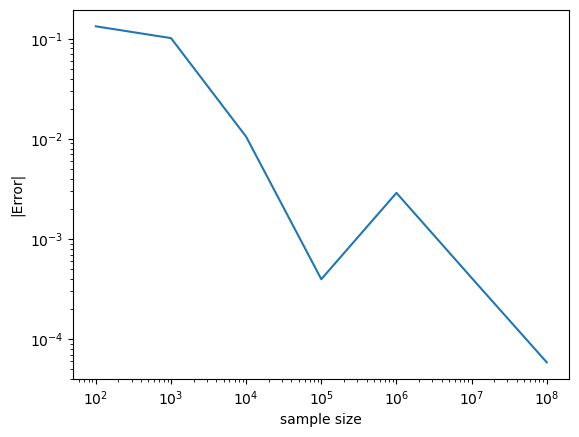

In [15]:
Ns = np.geomspace(100, 100000000, 7)
Is = np.array([Integrate_MC(f, g, invG, I=integral_of_g, a=a, b=b, N=int(N)) for N in Ns])

plt.plot(Ns, np.abs(Is - 3.29549))
plt.xlabel("sample size")
plt.ylabel("|Error|")

plt.loglog()
plt.show()

We try to integrate the same function f, but using a slightly different g

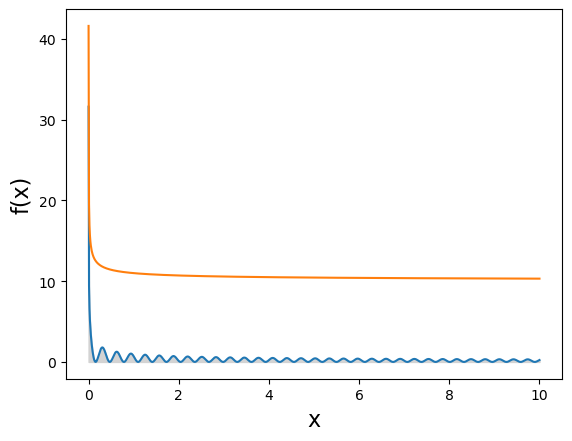

In [16]:
def f(x): 
    return np.cos(10*x)**2*x**-0.5

def g(x):
    return x**-0.5 + 10

def G(x):
    return 2*x**0.5 + 10*x

def invG(x):
    return 0.005*(4.+20.*x-4.*np.sqrt(1+10.*x))

x = np.linspace(0.001,10, 1000)
y = f(x)
plt.plot(x,y)
plt.fill_between(x,y, color='lightgray')
plt.plot(x,g(x))
plt.xlabel('x',size = 16)
plt.ylabel('f(x)', size = 16)
plt.show()

In [17]:
integral_of_g = G(b)
Integrate_MC(f, g, invG, I=integral_of_g, a=a, b=b, N=1000000)

3.2994636007006903

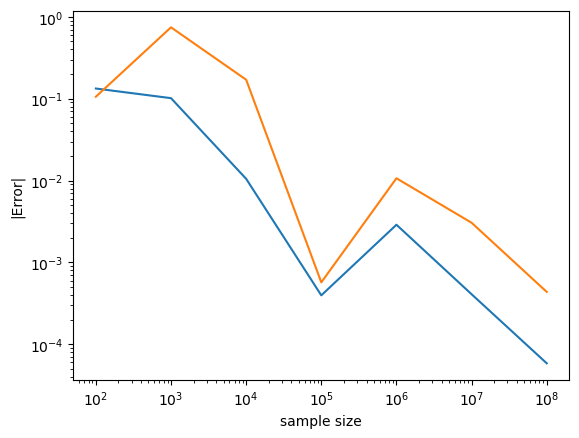

In [18]:
Is_2 = np.array([Integrate_MC(f, g, invG, I=integral_of_g, a=a, b=b, N=int(N)) for N in Ns])

plt.plot(Ns, np.abs(Is - 3.29549))
plt.plot(Ns, np.abs(Is_2 - 3.29549))
plt.xlabel("sample size")
plt.ylabel("|Error|")

plt.loglog()
plt.show()

On average, the closer g is to f, the smaller the error

## Mean value method

In [19]:
def Integrate_MVM(f, a, b, N):
    xs = (b-a)*rng.random(N) + a
    ys = f(xs)
    return  np.sum(ys) * (b-a)/ N

In [20]:
def f(x):
    return np.sin(x)**2/np.pi

Integrate_MVM(f, a=0, b=2*np.pi, N=1000000)

0.9988013725344461

In [21]:
def f(x): 
    return np.cos(10*x)**2*x**-0.5

Integrate_MVM(f, a=0, b=10, N=1000000)

3.3035207566172704

## Importance sampling

Integrate f on [0,1] using importance sampling

In [22]:
# Integrand function
def f(x): return x**(-0.5)/(np.exp(x)+1)

# Number of points in the sample
N = 1000000

# integration domain
a = 0
b = 1

# Sampling x_i: r.v. distributed as p(x) (see above)
x = rng.random(N)*(b-a) + a
x = np.array(x**2)

# Calculating (w(x_i)), for all sampled points
w = x**(-0.5)
# Calculating f(x_i), for all sampled points
fx = f(x)

# Implementing importance sampling formula with a=0, b=1 and noting that \int w(x)dx = 2
I = (2./float(N))*np.sum(fx/w)

print('I = ', I)

I =  0.8389576468190292


We repackage the algorithm in a function

In [23]:
def Integrate_IS(f, g, invG, I, a, b, N):
    xs = rng.random(N)
    xs = invG(xs*I)
    
    ws = g(xs)
    fs = f(xs)
    return np.sum(fs/ws)/N * I

In [24]:
def f(x):
    return x**(-0.5)/(np.exp(x)+1)

def g(x):
    return x**-0.5

def invG(x): # remember it has t be such that invG(0)=a
    return 0.25*x**2

I = 2

Integrate_IS(f, g, invG, I, a=0, b=1, N= 1000000)

0.8388701962199012

Tested on another function

In [25]:
def f(x): 
    return np.cos(10*x)**2*x**-0.5

def g(x):
    return x**-0.5

def invG(x):
    return 0.25*x**2

I = 6.32456

Integrate_IS(f, g, invG, I, a=0, b=10, N= 1000000)

3.2955273519192536

Same function, changing integration domain

In [26]:
def f(x): 
    return np.cos(10*x)**2*x**-0.5

def g(x):
    return x**-0.5

def invG(x): # remember it has t be such that invG(0)=a
    return 0.25*(2+x)**2 # that's the reason for the +2 added here

I = 4.32456

Integrate_IS(f, g, invG, I, a=1, b=10, N= 1000000)

2.1340914328460365